In [1]:
import sys
sys.path.append('../')
import tensorflow as tf
from modules.data_loaders import load_data_list_from_file, load_depth, load_img
from modules.model import BtsModel, bts_model, get_depthnet_with_downsizing
import numpy as np
from PIL import Image
from os import getenv, path
from matplotlib import pyplot as plt
from modules.image_utils import uint8_conv_mask, mask_normalize_uint16_disp, visualize_images_row, visualize_histograms_row
from modules.losses import total_loss, si_logloss, ssi_loss, mse_loss
from tabulate import tabulate

In [2]:
def noisy_tensor_f(mean, variance, scale = 1.0):
    def noisy_tensor(input_t):
        out = scale*input_t + tf.random.normal(input_t.shape) * variance + mean
        out = tf.clip_by_value(out, 0.0, 1.0)
        return out
    return noisy_tensor

Loading images from: /srv/beegfs02/scratch/efficient_nn_mobile/data/MAI2021_dataset/test_outputs/mai_winner_image_b32_128x160/test3_train
Orig image depth shape: (1, 128, 160, 1), type: <dtype: 'float32'>
Loss      Scale 0.0001 Mean 0.0 Var 0    Scale 0.001 Mean 0.0 Var 0    Scale 0.01 Mean 0.0 Var 0    Scale 0.1 Mean 0.0 Var 0
------  -----------------------------  ----------------------------  ---------------------------  --------------------------
si                        3.56705                       2.67539                      1.78355                     0.891779
ssi                       6.53076e-08                   7.73768e-08                  2.87627e-08                 5.70669e-08
mse                       0.047444                      0.0473586                    0.0465092                   0.0384373
total                     7.60853                       5.82437                      4.0322                      2.16793


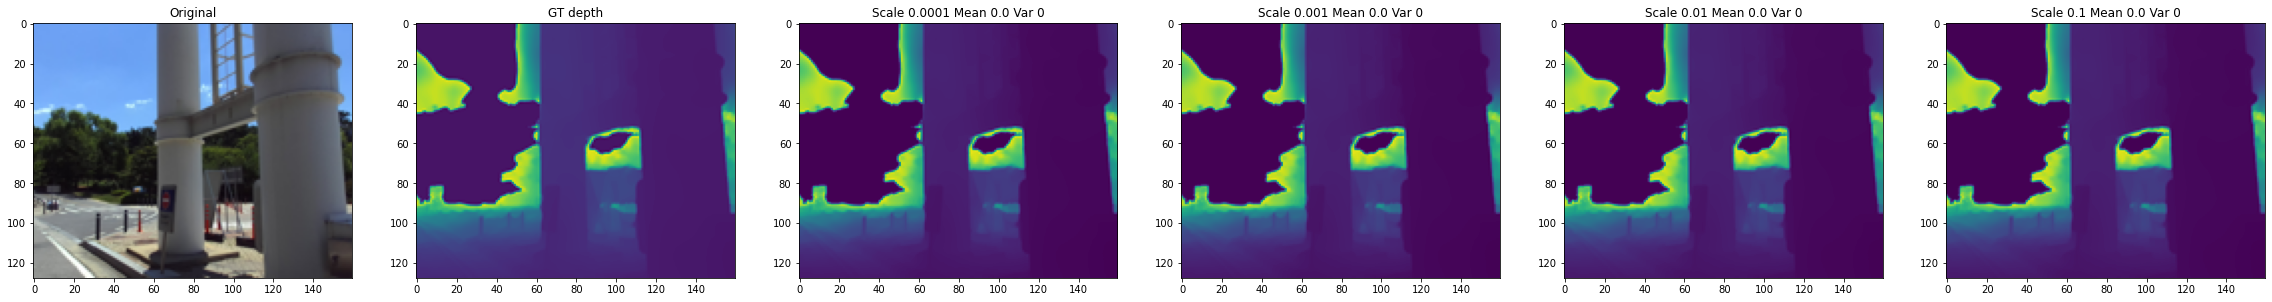

<Figure size 2880x1440 with 0 Axes>

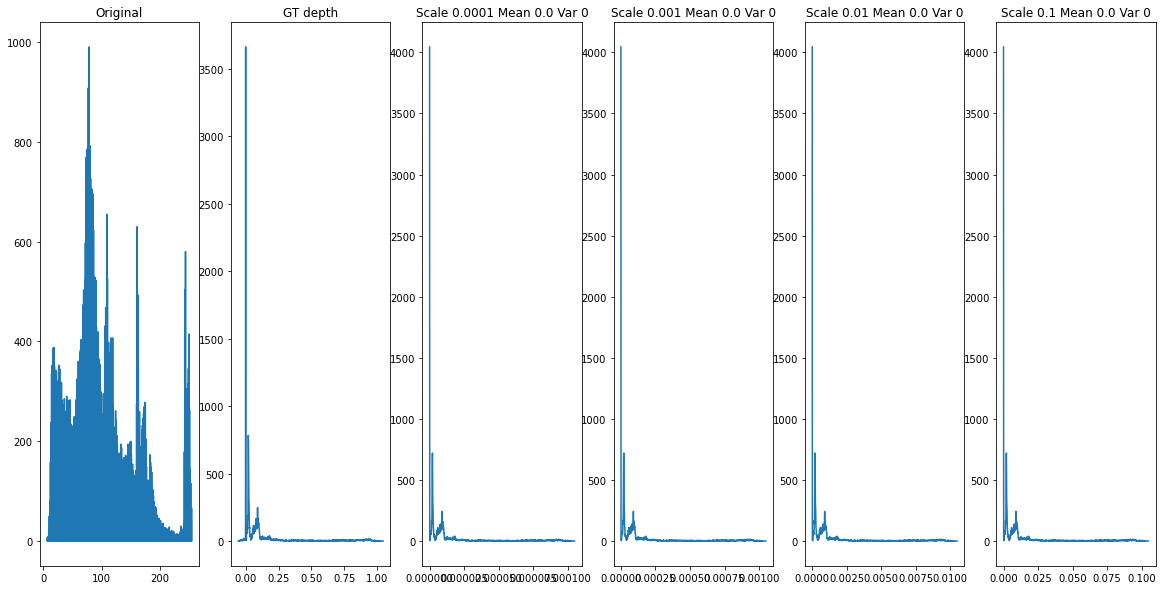

Orig image depth shape: (1, 128, 160, 1), type: <dtype: 'float32'>
Loss      Scale 0.0001 Mean 0.0 Var 0    Scale 0.001 Mean 0.0 Var 0    Scale 0.01 Mean 0.0 Var 0    Scale 0.1 Mean 0.0 Var 0
------  -----------------------------  ----------------------------  ---------------------------  --------------------------
si                        3.5671                        2.67539                      1.78352                     0.89176
ssi                       1.98049e-07                   1.73232e-07                  1.68883e-07                 1.75184e-07
mse                       0.118872                      0.118658                     0.11653                     0.0963055
total                     8.32293                       6.53736                      4.73234                     2.74658


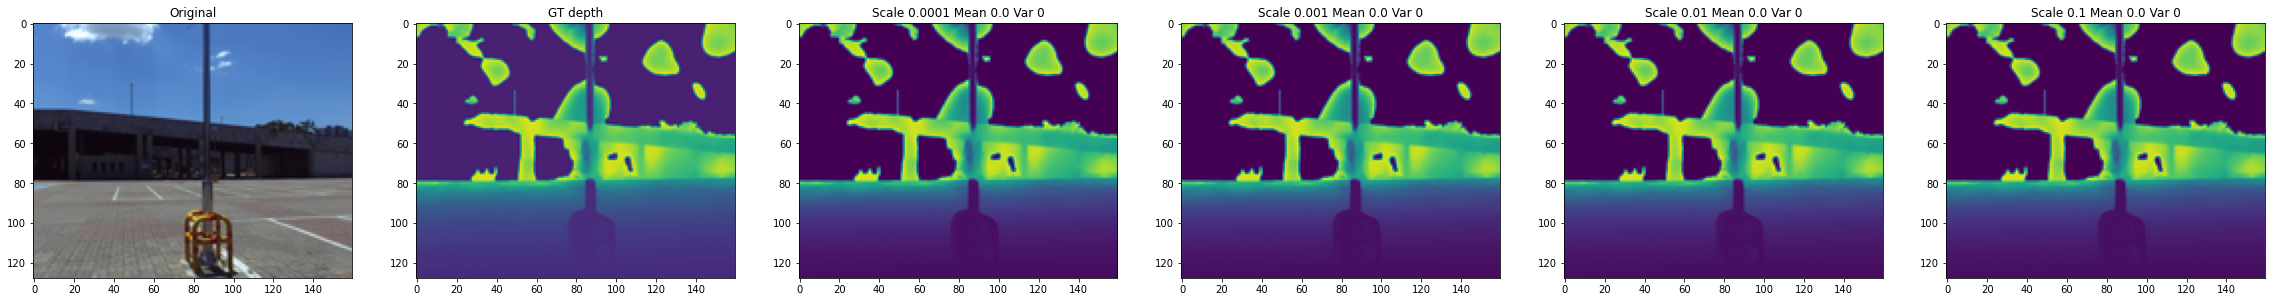

<Figure size 2880x1440 with 0 Axes>

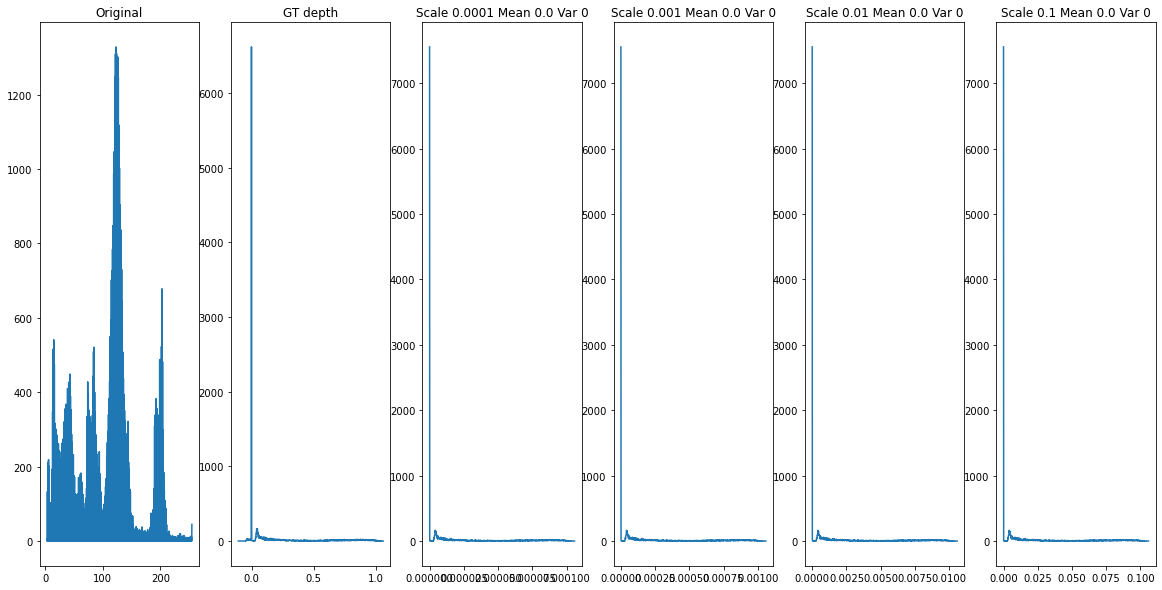

In [3]:
# Visualize outputs from test image
# Pick test_img_name accordingly. Note all output files will be in "output_di"
output_dir = getenv("DATA_DIR") +  '/MAI2021_dataset/test_outputs/mai_winner_image_b32_128x160/test3_train'

start_index = 10
num_images = 2
image_size = (128,160)

show_histograms = True
histogram_bins = 1000

import glob

all_images_list = sorted(glob.glob(output_dir + "/*"))
test_images = [path.basename(img_path).split(".")[0] for img_path in all_images_list[0::3]]

if num_images:
    test_images_disp = test_images[start_index: start_index+num_images]

print(f"Loading images from: {output_dir}")
# Losses
mask_threshold = 1e-5
variance_focus = 0.85
alpha = 0.5
mse_normalization = 'batch-based'
si_normalization = 'batch'
si_weight = 2.0
ssi_weight =10.0
mse_weight = 10.0

si = si_logloss(mask_threshold=mask_threshold, variance_focus=variance_focus, norm_type = si_normalization)
ssi = ssi_loss(mask_threshold=mask_threshold, alpha = alpha, scales = 4, normalization=mse_normalization)
mse = mse_loss(mask_threshold = mask_threshold, normalization = 'batch-based')
total = total_loss(mask_threshold=mask_threshold, variance_focus=variance_focus, alpha=alpha, scales=4, normalization=mse_normalization,
                si_normalization=si_normalization, si_weight = si_weight, ssi_weight=ssi_weight, mse_weight=mse_weight)

losses = [si, ssi, mse, total]
losses_names = ["si", "ssi", "mse", "total"]

# Noise additions to test errors
# variances = [0.0001, 0.001, 0.01, 0.1]
variances = np.array([0, 0, 0, 0])
means = np.array([0.0, 0.0, 0.0, 0.0])
scales = np.array([0.0001, 0.001, 0.01, 0.1])
transforms = [noisy_tensor_f(mean, variance, scale) for mean, variance, scale in zip(means,variances, scales)]

for i, test_img_name in enumerate(test_images_disp):
    img_original = np.array(Image.open(output_dir + '/' + test_img_name+'.png').resize(image_size[::-1]))
    img_original_depth = np.array(Image.open(output_dir + '/' + test_img_name + '_ori.png').resize(image_size[::-1]))
    
    mask = img_original_depth > 0
    
    img_original_depth = tf.convert_to_tensor(np.expand_dims(np.expand_dims(img_original_depth , 0), -1))
    img_original_depth = tf.cast(img_original_depth / (2**16-1), tf.float32)
    print(f"Orig image depth shape: {img_original_depth.shape}, type: {img_original_depth.dtype}")

    # Get losses for all noise cases
    errors_data = np.zeros((len(losses), len(variances)))
    images = [img_original, np.squeeze(img_original_depth.numpy())]
    imgs_titles = ['Original', 'GT depth']
    for j in range(len(transforms)):
        img_predicted_depth = transforms[j](img_original_depth)
        images.append(np.squeeze(img_predicted_depth.numpy()))
        imgs_titles.append(f"Scale {scales[j]} Mean {means[j]} Var {variances[j]}")
        for i in range(len(losses)):
            loss = losses[i](img_original_depth, img_predicted_depth)
            errors_data[i][j] = loss.numpy()
    losses_data = errors_data.tolist()

    # Put losses in table format
    table = []
    for i, row in enumerate(losses_data):
        table.append([losses_names[i]] + ["{}".format(elem) for elem in row])
    headers = ["Loss"] + imgs_titles[2:]
    print(tabulate(table, headers, tablefmt="plaine"))

    visualize_images_row(images, imgs_titles, figsize=(40,20))

    if show_histograms:
        plt.figure(figsize=(40,20))
        histograms = [np.histogram(img, histogram_bins) for img in images]
        visualize_histograms_row(histograms, imgs_titles)
        